<a href="https://colab.research.google.com/github/LeThanhLong2001/Classification-of-Loan-Borrowers/blob/main/Classification_of_loan_borrowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

About the dataset:
The data is about credit borrowers classification. The objective in this notebook is to build a suitable model that will be used to classify the credit borrowers.

Dataset: https://www.kaggle.com/code/kapturovalexander/classification-of-loan-borrowers

In [ ]:
# Authorise to the folder to load the file
!pip install -U -q PyDrive

# Install library to open .xlsb file formats
!pip install pyxlsb

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

**IMPORT LIBRARIES**

In [ ]:
# Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import set_option
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from pandas import read_csv, read_excel
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, roc_auc_score, recall_score, precision_score, f1_score

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from imblearn.over_sampling import RandomOverSampler # for imbalance
from imblearn.over_sampling import SMOTE


# Ignore the specific UserWarning about distplot
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

**READ DATASET**

In [ ]:
# List the files in the folder

file_names = ["Training.xlsb", "Test.xlsb"]
title = []
id = []

for file_name in file_names:
    query = f"title contains '{file_name}'"
    listed = drive.ListFile({'q': query}).GetList()

    for file in listed:
        print('Title: {}, ID: {}'.format(file['title'], file['id']))
        title.append(file['title'])
        id.append(file['id'])

Title: Training.xlsb, ID: 18mLnmuUQXwj-zQN7TDUTuE518g6eI-d6
Title: Test.xlsb, ID: 1F6OvD1kuR7qfO1ORk_VekjYydwzLYUEH


In [ ]:
download_path = os.path.expanduser('~/Nguyễn Huy Thành/Dataset/')
try:
  os.makedirs(download_path)
except FileExistsError:
  pass

In [ ]:
def load_file(download_path, file_name, file_id):
    output_file = os.path.join(download_path, file_name)
    temp_file = drive.CreateFile({'id': file_id})
    temp_file.GetContentFile(output_file)
    df = pd.read_excel(output_file)
    return df

In [ ]:
train = load_file(download_path, title[0], id[0])
test = load_file(download_path, title[1], id[1])

**EDA**

In [ ]:
# Show the first 5 lines of train file
pd.set_option('display.max_columns', None)  # show all properties on display
train.head()

,ID,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,MARKER
0,1,0.20,0.10,0.00,799.90,1.78,0.89,13,3.49,Woman,33.75,Mogilev region,132,NE employee,Secondary education (plus special education),Married,2 Two,property,No,Works,Yes,Yes,No,Yes,No,0
1,2,0.04,0.02,49.97,173.03,0.38,0.19,13,3.49,Woman,33.25,Minsk region,6,NE employee,Secondary education (plus special education),Married,2 Two,otherwise,No,Works,Yes,Yes,Yes,Yes,No,0
2,3,0.07,0.07,0.00,329.90,0.60,0.60,13,3.49,Woman,38.58,Vitebsk region,71,NE employee,Secondary education (plus special education),Divorced/widow,1 One,property,No,No couple,No,Yes,No,Yes,No,0
3,4,0.05,0.05,0.00,235.65,0.47,0.47,13,3.49,Woman,61.25,Minsk region,48,Pensioner,Secondary education (plus special education),Divorced/widow,0 Zero,property,No,No couple,Yes,Yes,Few,Yes,No,0
4,5,0.14,0.14,0.00,634.45,1.27,1.27,13,3.49,Woman,48.58,Brest region,48,NE employee,Secondary education (plus special education),Divorced/widow,0 Zero,property,No,No couple,Yes,No,No,No,No,0


In [ ]:
#Rename some properties' names
#Reference:Authors Notebook
train.rename(columns={'I': 'Sex'}, inplace=True)
train.rename(columns={'K': 'Region'}, inplace=True)
train.rename(columns={'M': 'Job_title'}, inplace=True)
train.rename(columns={'N': 'Education'}, inplace=True)
train.rename(columns={'O': 'Marriage'}, inplace=True)
train.rename(columns={'P': 'Children'}, inplace=True)
train.rename(columns={'Q': 'Property'}, inplace=True)
train.rename(columns={'S': 'Employment_status'}, inplace=True)

test.rename(columns={'I': 'Sex'}, inplace=True)
test.rename(columns={'K': 'Region'}, inplace=True)
test.rename(columns={'M': 'Job_title'}, inplace=True)
test.rename(columns={'N': 'Education'}, inplace=True)
test.rename(columns={'O': 'Marriage'}, inplace=True)
test.rename(columns={'P': 'Children'}, inplace=True)
test.rename(columns={'Q': 'Property'}, inplace=True)
test.rename(columns={'S': 'Employment_status'}, inplace=True)

In [ ]:
# Double check column names
train.columns

Index(['ID', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Sex', 'J', 'Region', 'L',
       'Job_title', 'Education', 'Marriage', 'Children', 'Property', 'R',
       'Employment_status', 'T', 'U', 'V', 'W', 'X', 'MARKER'],
      dtype='object')

In [ ]:
train.head()

,ID,A,B,C,D,E,F,G,H,Sex,J,Region,L,Job_title,Education,Marriage,Children,Property,R,Employment_status,T,U,V,W,X,MARKER
0,1,0.20,0.10,0.00,799.90,1.78,0.89,13,3.49,Woman,33.75,Mogilev region,132,NE employee,Secondary education (plus special education),Married,2 Two,property,No,Works,Yes,Yes,No,Yes,No,0
1,2,0.04,0.02,49.97,173.03,0.38,0.19,13,3.49,Woman,33.25,Minsk region,6,NE employee,Secondary education (plus special education),Married,2 Two,otherwise,No,Works,Yes,Yes,Yes,Yes,No,0
2,3,0.07,0.07,0.00,329.90,0.60,0.60,13,3.49,Woman,38.58,Vitebsk region,71,NE employee,Secondary education (plus special education),Divorced/widow,1 One,property,No,No couple,No,Yes,No,Yes,No,0
3,4,0.05,0.05,0.00,235.65,0.47,0.47,13,3.49,Woman,61.25,Minsk region,48,Pensioner,Secondary education (plus special education),Divorced/widow,0 Zero,property,No,No couple,Yes,Yes,Few,Yes,No,0
4,5,0.14,0.14,0.00,634.45,1.27,1.27,13,3.49,Woman,48.58,Brest region,48,NE employee,Secondary education (plus special education),Divorced/widow,0 Zero,property,No,No couple,Yes,No,No,No,No,0


In [ ]:
# Check data shape of train & test files
print('Train: {}'.format(train.shape))
print('Test: {}'.format(test.shape))

Train: (89734, 26)
Test: (38405, 26)


In [ ]:
# descriptions
set_option('display.precision', 3)
train.describe()

,ID,A,B,C,D,E,F,G,H,J,L,MARKER
count,89734.000,8.973e+04,8.973e+04,89734.000,89734.000,8.973e+04,8.973e+04,89734.000,89734.000,89734.000,89734.000,89734.000
mean,44867.500,1.679e-01,1.135e-01,85.801,548.508,1.011e+00,6.836e-01,7.854,0.510,41.141,103.719,0.004
std,25904.119,1.539e-01,1.053e-01,105.367,448.686,9.106e-01,6.220e-01,4.755,0.928,11.130,100.458,0.062
min,1.000,1.628e-06,1.206e-06,0.000,49.980,1.599e-05,1.184e-05,2.000,0.000,21.000,0.000,0.000
25%,22434.250,6.584e-02,4.292e-02,20.570,227.030,4.060e-01,2.638e-01,4.000,0.000,32.083,29.000,0.000
50%,44867.500,1.191e-01,7.973e-02,50.020,408.735,7.494e-01,4.994e-01,5.000,0.000,40.000,69.000,0.000
75%,67300.750,2.200e-01,1.470e-01,108.930,746.710,1.333e+00,8.993e-01,13.000,0.010,50.000,144.000,0.000
max,89734.000,7.067e+00,8.740e-01,2682.420,4999.000,3.534e+01,1.035e+01,24.000,3.500,64.917,540.000,1.000


In [ ]:
# information of train data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89734 entries, 0 to 89733
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 89734 non-null  int64  
 1   A                  89734 non-null  float64
 2   B                  89734 non-null  float64
 3   C                  89734 non-null  float64
 4   D                  89734 non-null  float64
 5   E                  89734 non-null  float64
 6   F                  89734 non-null  float64
 7   G                  89734 non-null  int64  
 8   H                  89734 non-null  float64
 9   Sex                89734 non-null  object 
 10  J                  89734 non-null  float64
 11  Region             89734 non-null  object 
 12  L                  89734 non-null  int64  
 13  Job_title          89734 non-null  object 
 14  Education          89734 non-null  object 
 15  Marriage           89734 non-null  object 
 16  Children           897

In [ ]:
# Checking for duplication
train.duplicated().sum()

0

In [ ]:
#Seeing the number of unique values
train.nunique()

ID                   89734
A                    46408
B                    56381
C                    11051
D                    14941
E                    49962
F                    59471
G                       11
H                       13
Sex                      2
J                      528
Region                   7
L                      511
Job_title                5
Education                4
Marriage                 4
Children                 5
Property                 3
R                        2
Employment_status        5
T                        2
U                        2
V                        3
W                        2
X                        2
MARKER                   2
dtype: int64

**Finding:**
*   The train dataset has data on 89734 customers.
*   There are 9 categorical columns including Sex, Region, Job_title, Education, Marriage, Children, Property, Employment_status, V.
*   There are 5 bolean variables: R, T, U, W, X.
*   The remaining 12 columns are numeric columns.
*   ID column is just the ID of the customer, so it doesn't contribute to the models.
*   No missing value in the dataset
*   No duplicated value in the dataset

In [ ]:
# Drop ID column
train = train.drop(columns='ID')
test = test.drop(columns='ID')

In [ ]:
# split categorical and numeric features for EDA
train.columns

categorical_columns = []
numeric_columns = []

for col in train.columns:
  if train[col].dtype == 'object':
    categorical_columns.append(col)
  else:
    numeric_columns.append(col)

print('Categorical columns: \n {}'.format(categorical_columns))
print('Numeric columns: \n {}'.format(numeric_columns))

Categorical columns: 
 ['Sex', 'Region', 'Job_title', 'Education', 'Marriage', 'Children', 'Property', 'R', 'Employment_status', 'T', 'U', 'V', 'W', 'X']
Numeric columns: 
 ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'L', 'MARKER']


**Numeric variables**

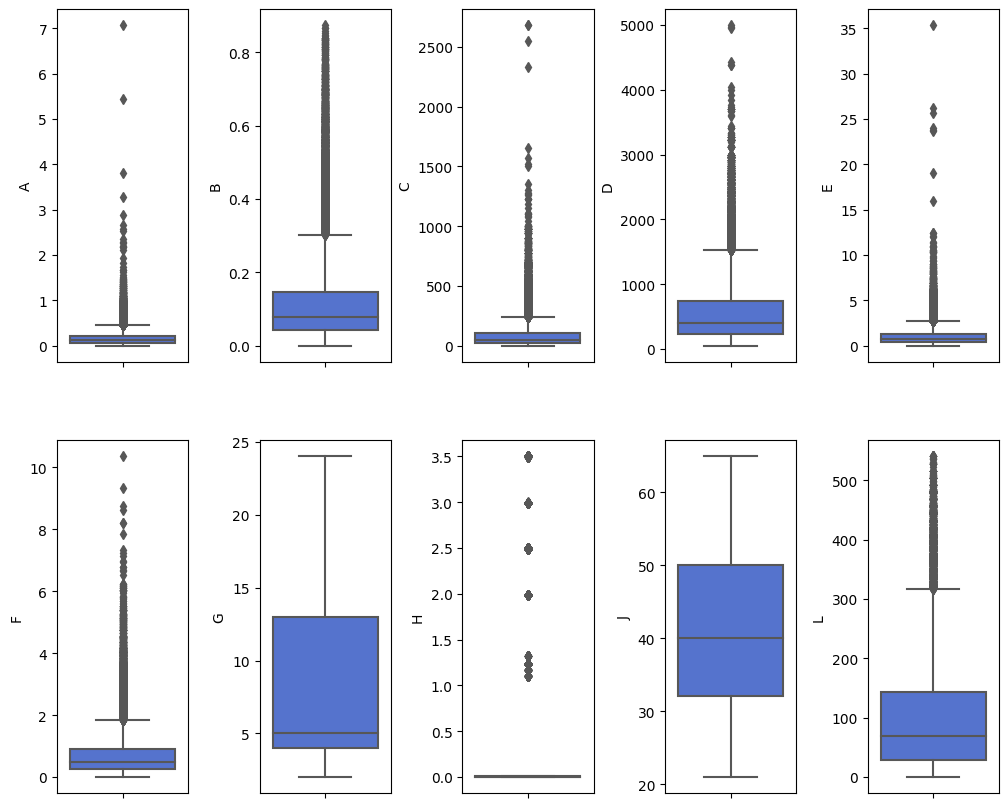

In [ ]:
# Drop 'MARKER' columns
numeric_columns = [item for item in numeric_columns if item not in ['MARKER']]
num_train = train[numeric_columns]
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(10, 8))
index = 0
axs = axs.flatten()
for k,v in num_train.items():
    sns.boxplot(y=k, data=num_train, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [ ]:
# Checking the outliners
for k, v in num_train.items():
  q1 = v.quantile(0.25)
  q3 = v.quantile(0.75)
  irq = q3 - q1
  v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
  perc = np.shape(v_col)[0] * 100.0 / np.shape(num_train)[0]
  print("Column %s outliers = %.2f%%" % (k, perc))

Column A outliers = 5.62%
Column B outliers = 6.11%
Column C outliers = 7.75%
Column D outliers = 3.97%
Column E outliers = 4.84%
Column F outliers = 5.15%
Column G outliers = 0.00%
Column H outliers = 23.71%
Column J outliers = 0.00%
Column L outliers = 5.20%


[]

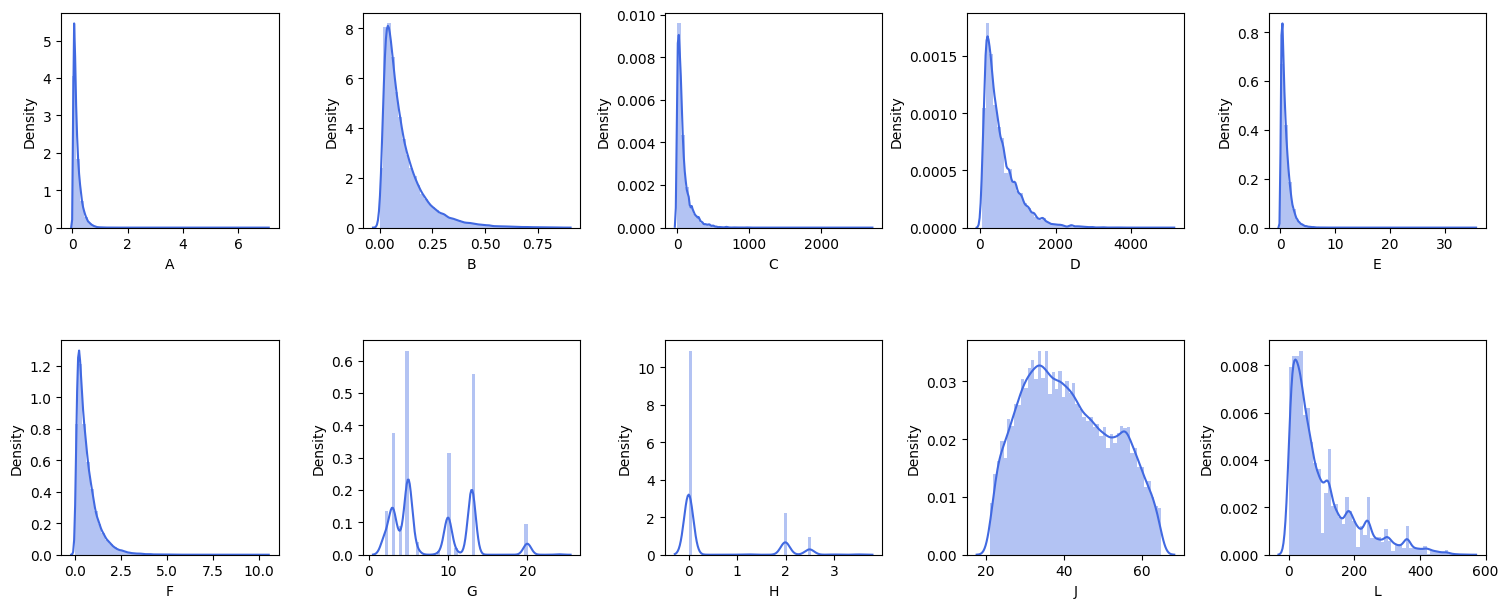

In [ ]:
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(15, 6))
index = 0
axs = axs.flatten()
for k,v in num_train.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)
plt.plot()

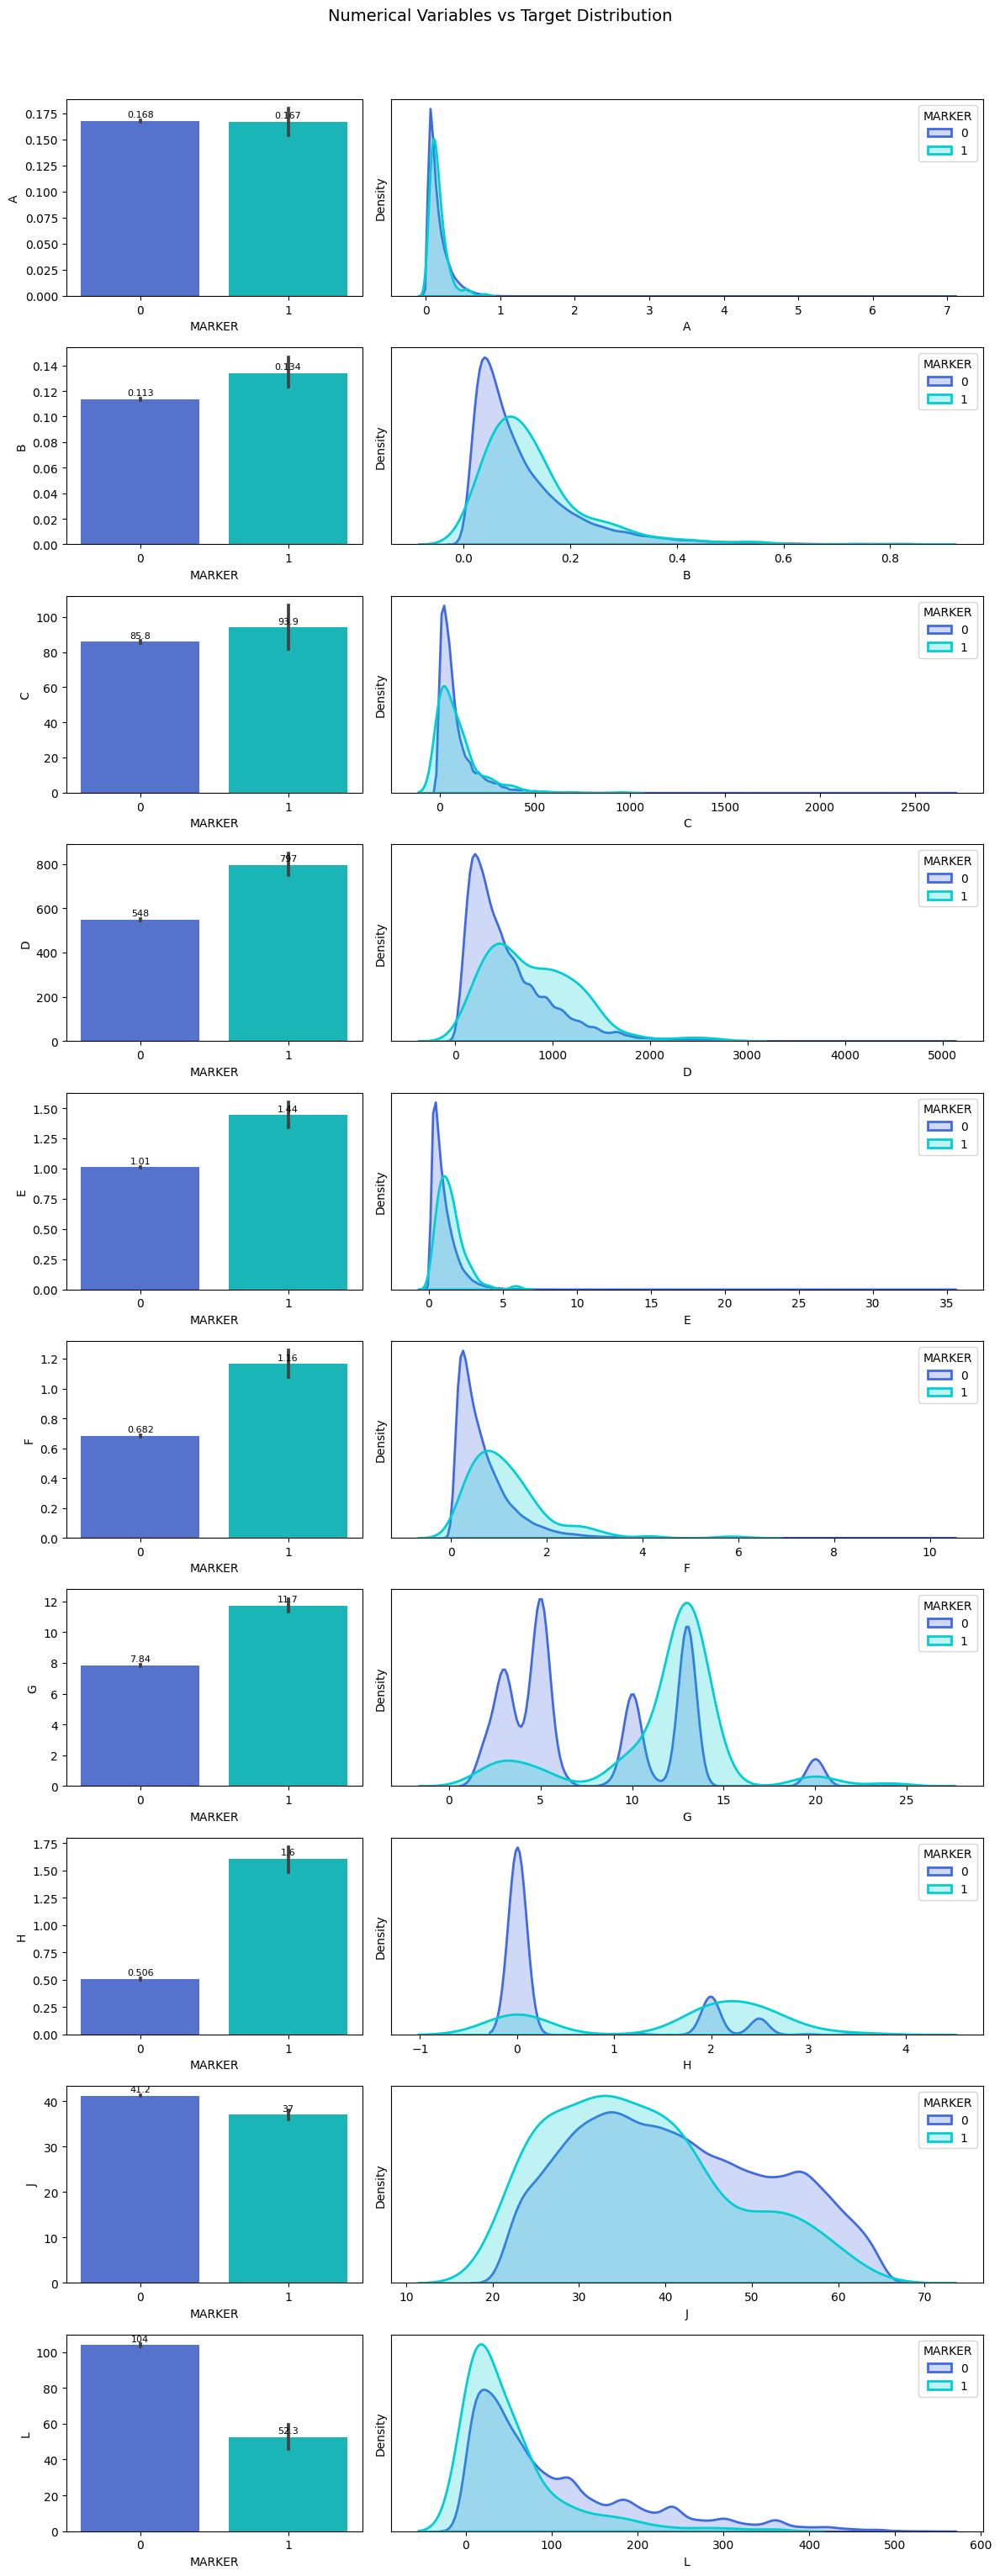

In [ ]:
# NUMERICAL VARIABLES WITH TARGET
# Set the Seaborn palette
sns.set_palette(['royalblue', 'darkturquoise'])

# Create subplots
fig, ax = plt.subplots(10, 2, figsize=(12, 30), dpi=100, gridspec_kw={'width_ratios': [1, 2]})

for i, col in enumerate(numeric_columns):
    # Barplot
    graph = sns.barplot(data=train, x='MARKER', y=col, ax=ax[i, 0])

    # KDE Plot
    sns.kdeplot(data=train[train['MARKER'] == 0], x=col, fill=True, linewidth=2, ax=ax[i, 1], label='0')
    sns.kdeplot(data=train[train['MARKER'] == 1], x=col, fill=True, linewidth=2, ax=ax[i, 1], label='1')
    ax[i, 1].set_yticks([])
    ax[i, 1].legend(title='MARKER', loc='upper right')

    # Add bar sizes to the bar plot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='%.3g', label_type='edge', fontsize=8, padding=2)

# Add a main title
plt.suptitle('Numerical Variables vs Target Distribution', fontsize=14, y=1.02)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

<ipython-input-76-dd2dbbab38c7>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = train.corr(method='pearson')


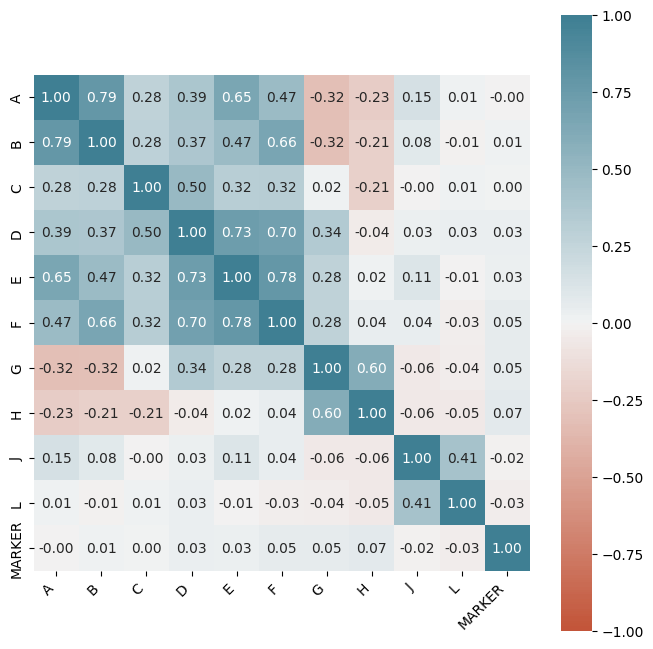

In [ ]:
# Correlation of numeric variables
pd.set_option('display.precision', 2)  # Set precision to 2 decimal places
cor = train.corr(method='pearson')

fig, ax = plt.subplots(figsize=(8,8))         # Sample figsize in inches
sns.heatmap(
    cor,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax,
    annot=True,
    fmt=".2f"
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

**Finding:**
*   Customers with higher score in B, D, E, F, L tend to be marked as 1 in the MARKER
*   Customers with lower score in G tend to marked as 0 in the MARKER
*   It seems A, H has no strong effect on the MARKER
*   (A, B) and (D, E) seem to have strong linear correlation



**Categorical variables**

In [ ]:
# EDA of categorical_columns
cat_train_columns = categorical_columns[0:] + ['MARKER']
cat_train = train[cat_train_columns]
cat_train.head()

,Sex,Region,Job_title,Education,Marriage,Children,Property,R,Employment_status,T,U,V,W,X,MARKER
0,Woman,Mogilev region,NE employee,Secondary education (plus special education),Married,2 Two,property,No,Works,Yes,Yes,No,Yes,No,0
1,Woman,Minsk region,NE employee,Secondary education (plus special education),Married,2 Two,otherwise,No,Works,Yes,Yes,Yes,Yes,No,0
2,Woman,Vitebsk region,NE employee,Secondary education (plus special education),Divorced/widow,1 One,property,No,No couple,No,Yes,No,Yes,No,0
3,Woman,Minsk region,Pensioner,Secondary education (plus special education),Divorced/widow,0 Zero,property,No,No couple,Yes,Yes,Few,Yes,No,0
4,Woman,Brest region,NE employee,Secondary education (plus special education),Divorced/widow,0 Zero,property,No,No couple,Yes,No,No,No,No,0


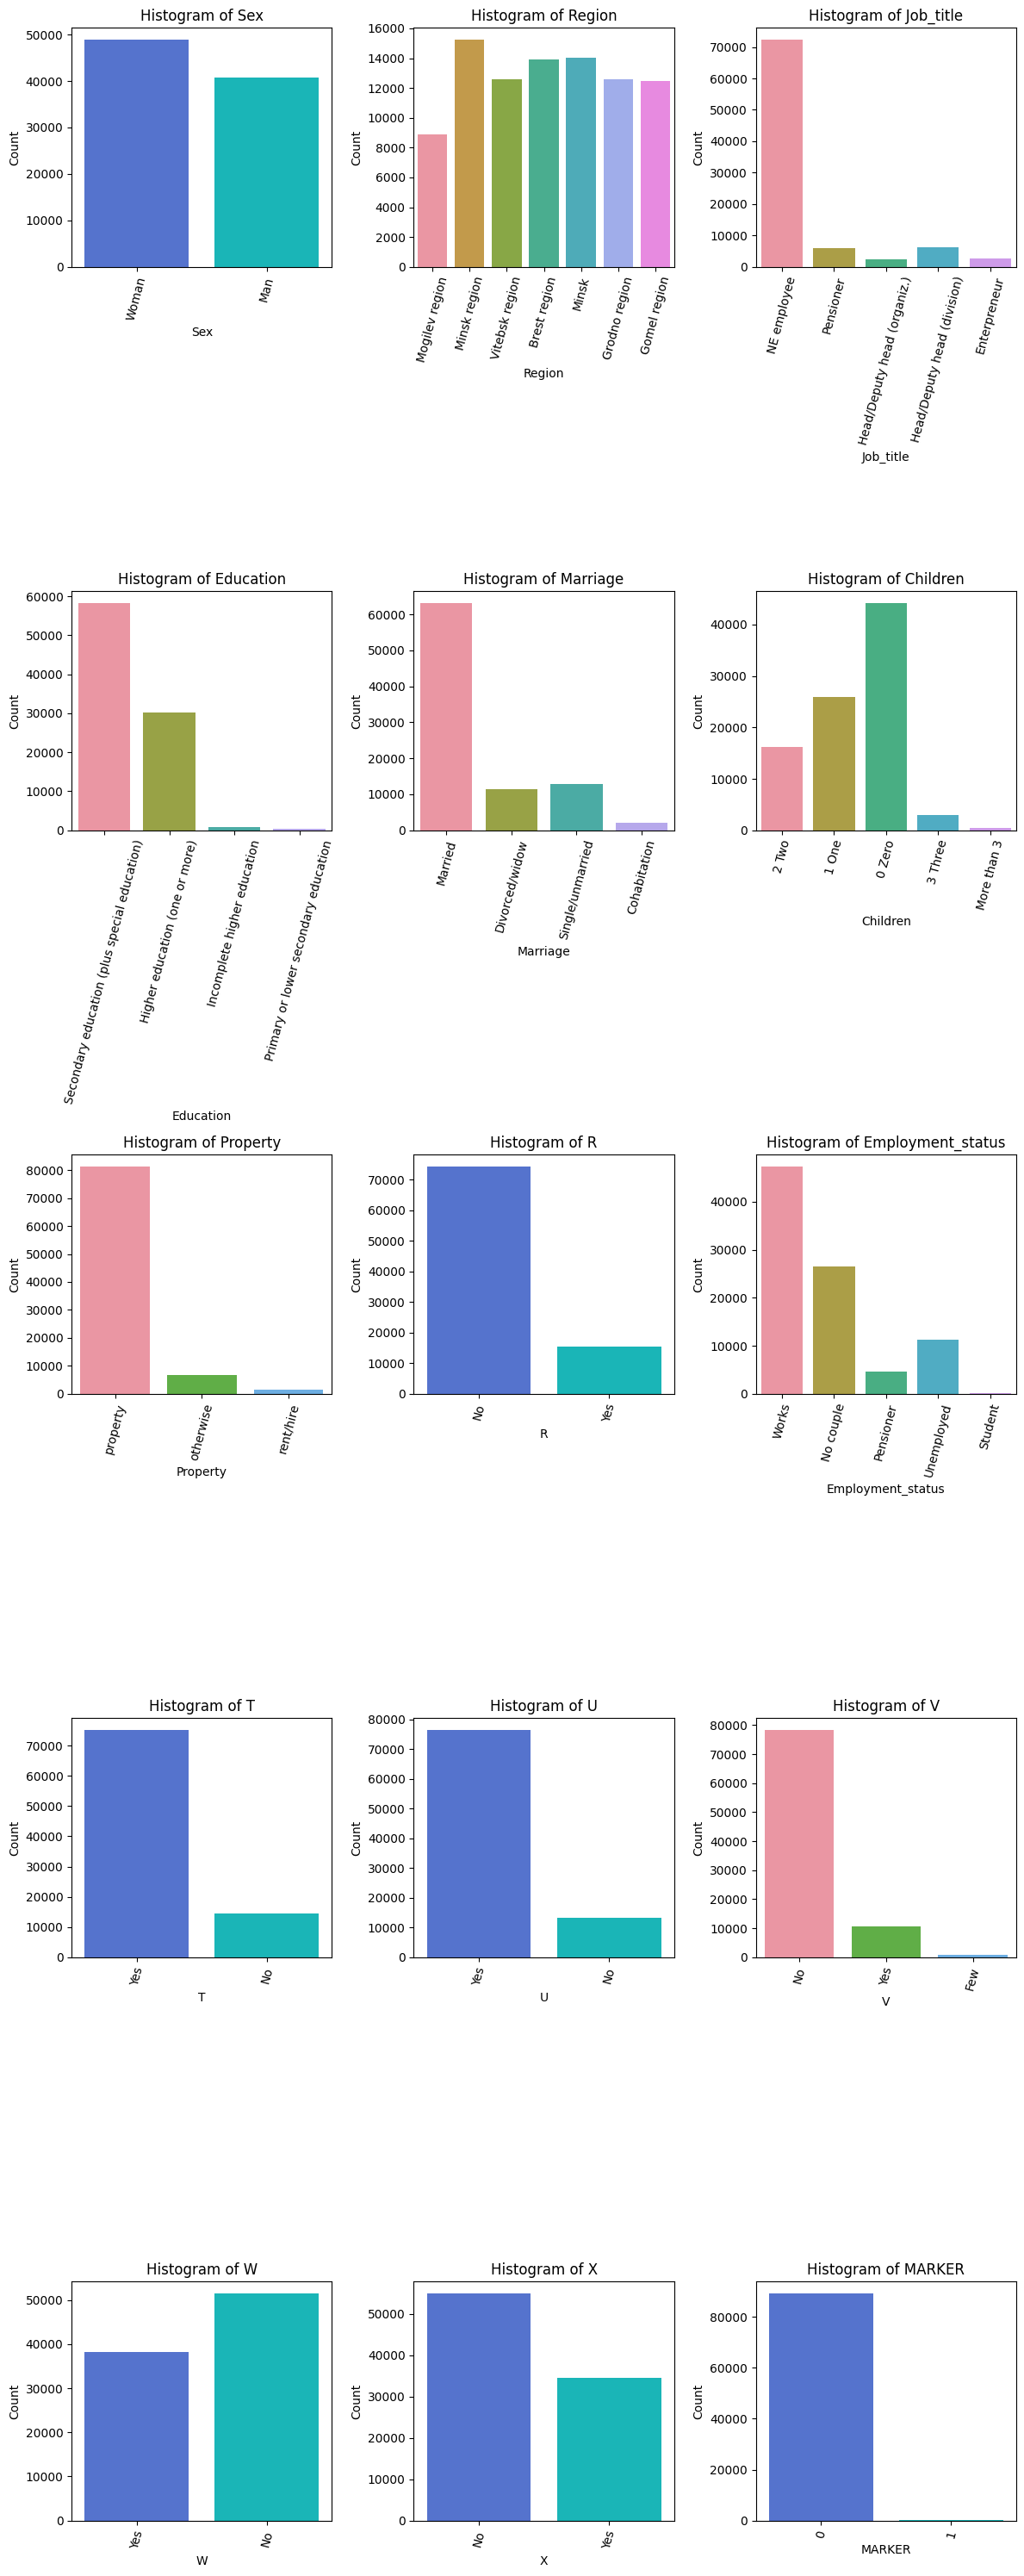

In [ ]:
# Calculate the number of rows and columns for subplots
num_rows = 5
num_columns = 3

# Set up the subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, num_rows * 6))
fig.subplots_adjust(hspace=0.5)

# Create histograms
for i, column in enumerate(cat_train_columns):
    row = i // num_columns
    col = i % num_columns
    ax = axes[row, col]

    sns.countplot(x=column, data=cat_train, ax=ax)
    ax.set_title('Histogram of {}'.format(column))
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=75)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

**Finding:**
*   Majority of customers are NE employee
*   Around 50% of customers are at secondary education, fews are not complete education or primarity education
*   Majority of customers are married, and don't have kids yet.
*   Around 80-90% are having property
*   50% of customers are having job.
*   '> 95% of data has the value MARKER at 0. The dataset is **imbalanced**.

**PRE-PROCESSING DATA**

In [ ]:
# CHECKING THE DISTRIBUTION OF TEST DATA
""" If test data has different distribution, we can consider to concat the train and test data and split again"""
# Splitting X_test and y_test
X_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1]

In [ ]:
# split categorical and numeric features for double checking the test dataset
test.columns

test_categorical_columns = []
test_numeric_columns = []

for col in test.columns:
  if test[col].dtype == 'object':
    test_categorical_columns.append(col)
  else:
    test_numeric_columns.append(col)

print('Test categorical columns: \n {}'.format(test_categorical_columns))
print('Test numeric columns: \n {}'.format(test_numeric_columns))

Test categorical columns: 
 ['Sex', 'Region', 'Job_title', 'Education', 'Marriage', 'Children', 'Property', 'R', 'Employment_status', 'T', 'U', 'V', 'W', 'X']
Test numeric columns: 
 ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'L', 'MARKER']


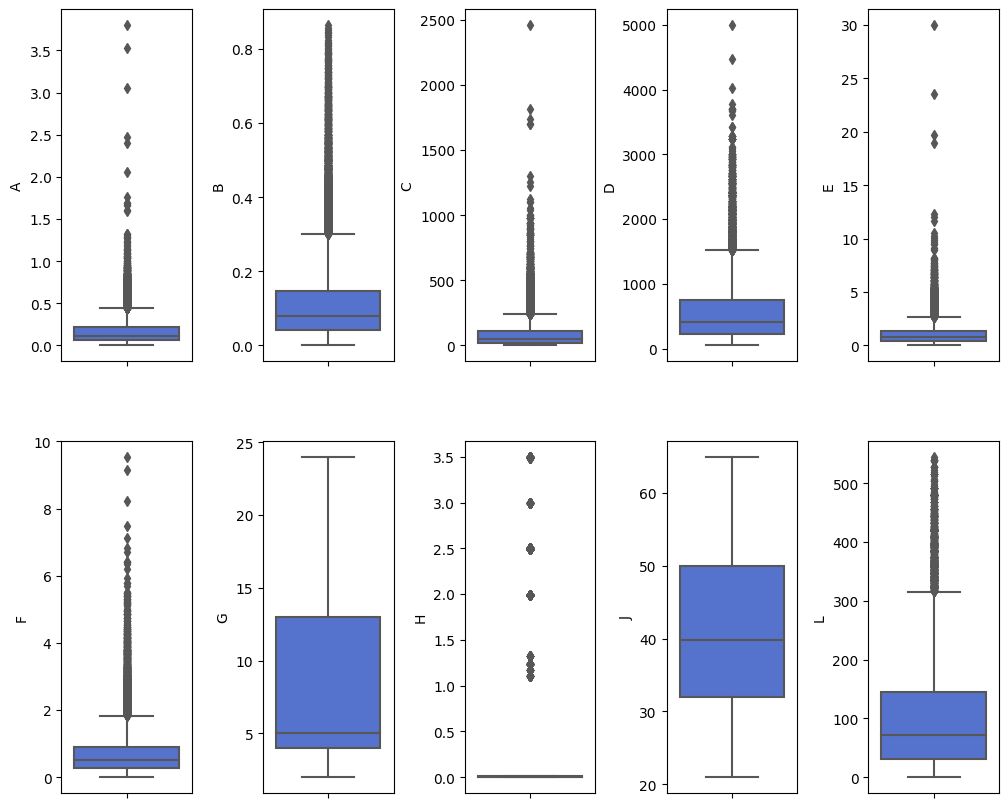

In [ ]:
# Distribution of test_numeric_columns
test_num_train = test[test_numeric_columns].drop(columns=['MARKER'])
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(10, 8))
index = 0
axs = axs.flatten()
for k,v in test_num_train.items():
    sns.boxplot(y=k, data=test_num_train, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [ ]:
# Distribution of categorical_columns (Test dataset)
cat_test_columns = test_categorical_columns[0:] + ['MARKER']
cat_test = test[cat_test_columns]
cat_test.head()

,Sex,Region,Job_title,Education,Marriage,Children,Property,R,Employment_status,T,U,V,W,X,MARKER
0,Woman,Minsk region,NE employee,Secondary education (plus special education),Single/unmarried,1 One,property,No,No couple,Yes,Yes,No,No,No,0
1,Woman,Vitebsk region,NE employee,Secondary education (plus special education),Married,3 Three,property,No,Works,Yes,Yes,No,No,No,1
2,Man,Vitebsk region,Head/Deputy head (division),Secondary education (plus special education),Married,0 Zero,property,No,Unemployed,Yes,Yes,No,No,No,0
3,Man,Gomel region,NE employee,Secondary education (plus special education),Married,1 One,property,No,Unemployed,Yes,Yes,Yes,Yes,No,0
4,Woman,Minsk region,Head/Deputy head (division),Higher education (one or more),Married,1 One,property,No,Works,Yes,Yes,No,No,No,0


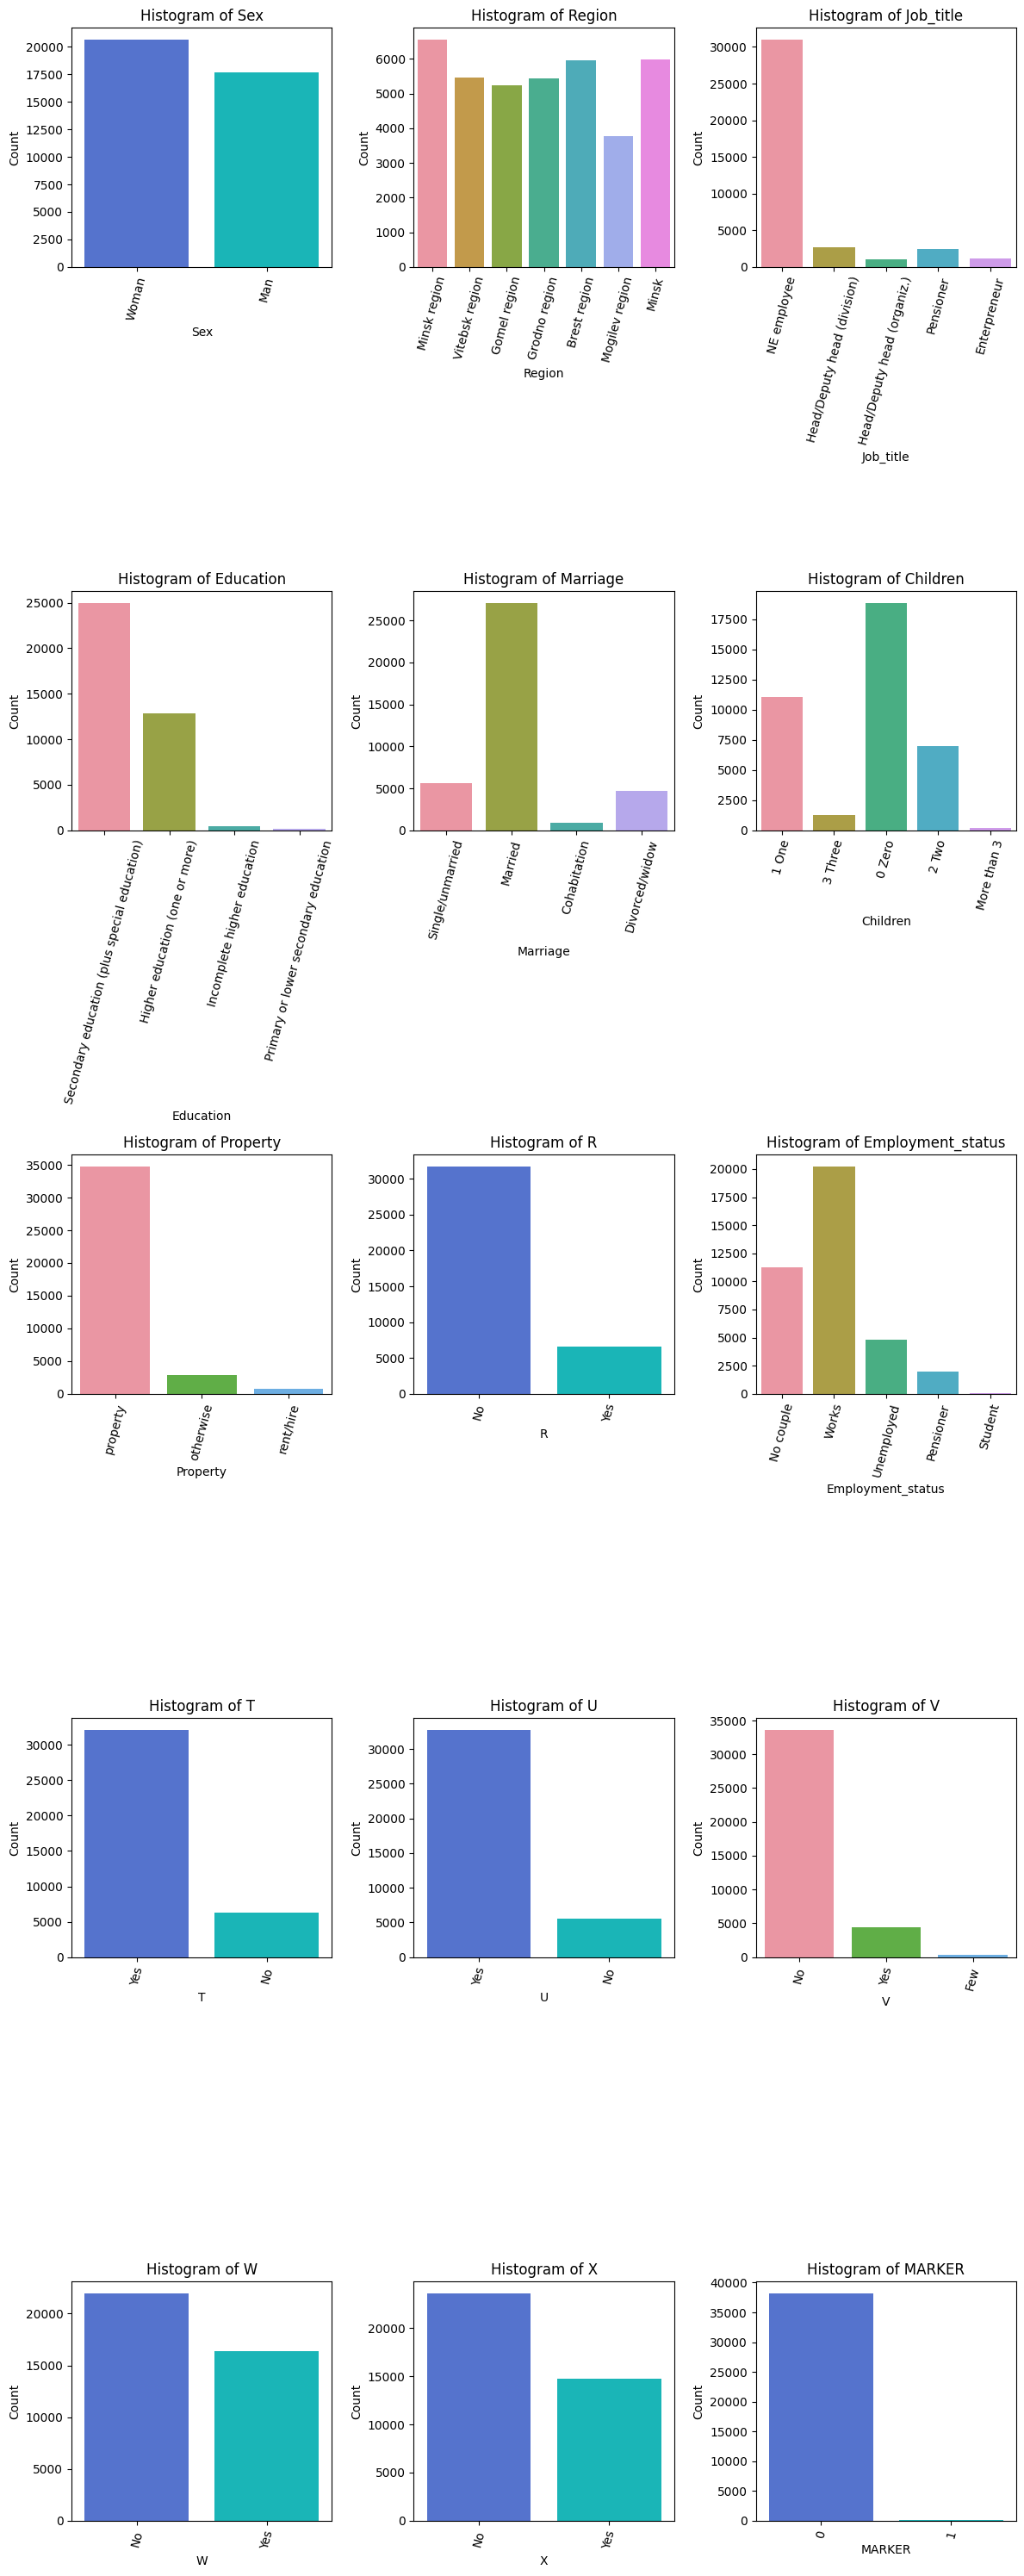

In [ ]:
# Calculate the number of rows and columns for subplots
test_num_rows = 5
test_num_columns = 3

# Set up the subplots
fig, axes = plt.subplots(test_num_rows, test_num_columns, figsize=(12, test_num_rows * 6))
fig.subplots_adjust(hspace=0.5)

# Create histograms
for i, column in enumerate(cat_test_columns):
    row = i // test_num_columns
    col = i % test_num_columns
    ax = axes[row, col]

    sns.countplot(x=column, data=cat_test, ax=ax)
    ax.set_title('Histogram of {}'.format(column))
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=75)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

**Finding:** Test data has a similar distribution to the train data. So it is not neccessary to concat data



In [ ]:
# Splitting X and y train
X_train = train.iloc[:, :-1]
y_train = train.iloc[:, -1]
# Splitting X and y test
X_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1]

In [ ]:
# Categorical variables
categorical_cols = X_train.select_dtypes(include=['object','category']).columns.to_list()
# Numerical variables
numerical_cols = X_train.select_dtypes(include=['int','float']).columns.to_list()

In [ ]:
categorical_cols

['Sex',
 'Region',
 'Job_title',
 'Education',
 'Marriage',
 'Children',
 'Property',
 'R',
 'Employment_status',
 'T',
 'U',
 'V',
 'W',
 'X']

In [ ]:
numerical_cols

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'L']

In [ ]:
# Define preprocessor
# OneHotEncoder encoding for qualitative variables.
preprocesador = ColumnTransformer([('ohe',OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
                                    categorical_cols)], remainder = 'passthrough',verbose_feature_names_out=False).set_output(transform='pandas')

# We fit and transform our train data.
X_train_prep = preprocesador.fit_transform(X_train)

## We transform our test set.
X_test_prep = preprocesador.transform(X_test)

# We show the size of our data sets
print('Training Set Size: {}'.format(X_train_prep.shape))
print('Testing Set Size: {}'.format(X_test_prep.shape))

Training Set Size: (89734, 58)
Testing Set Size: (38405, 58)


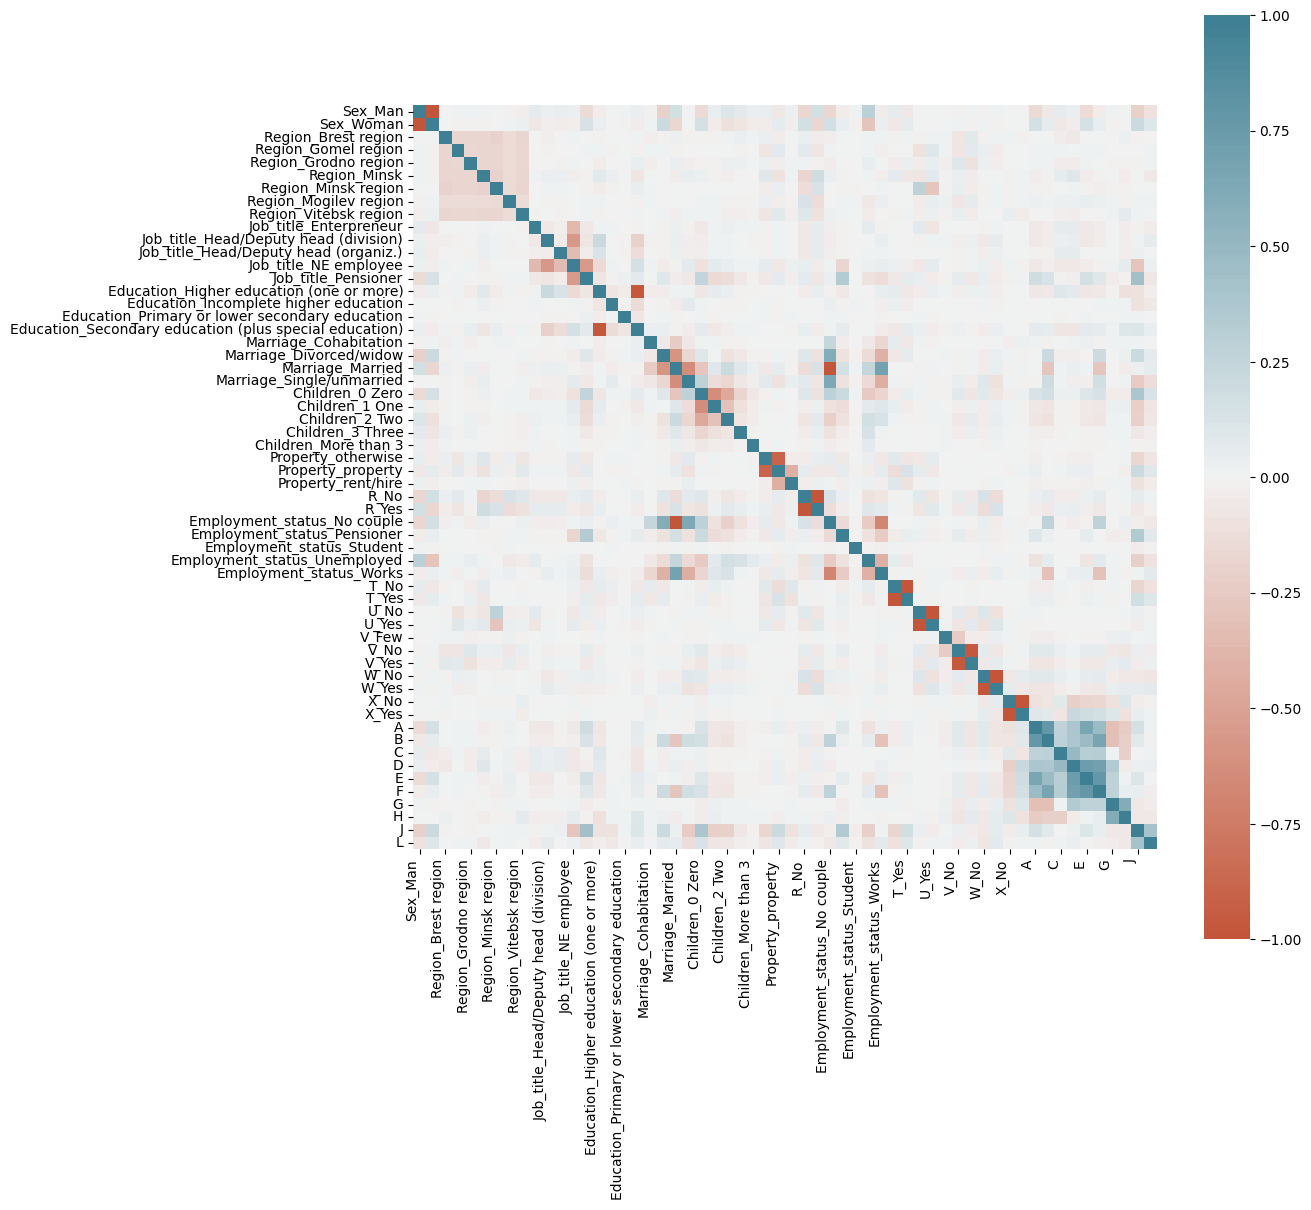

In [ ]:
# Correlation
pd.set_option('display.precision', 2)  # Set precision to 2 decimal places
cor = X_train_prep.corr(method='pearson')

fig, ax = plt.subplots(figsize=(12,12))         # Sample figsize in inches
sns.heatmap(
    cor,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    ax=ax,
    annot=False,
    fmt=".2f"
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
)
plt.show()

In [ ]:
# Correlation in X_train_prep
correlation = X_train_prep.corr()
correlation.style.background_gradient(cmap='PuBu')

,Sex_Man,Sex_Woman,Region_Brest region,Region_Gomel region,Region_Grodno region,Region_Minsk,Region_Minsk region,Region_Mogilev region,Region_Vitebsk region,Job_title_Enterpreneur,Job_title_Head/Deputy head (division),Job_title_Head/Deputy head (organiz.),Job_title_NE employee,Job_title_Pensioner,Education_Higher education (one or more),Education_Incomplete higher education,Education_Primary or lower secondary education,Education_Secondary education (plus special education),Marriage_Cohabitation,Marriage_Divorced/widow,Marriage_Married,Marriage_Single/unmarried,Children_0 Zero,Children_1 One,Children_2 Two,Children_3 Three,Children_More than 3,Property_otherwise,Property_property,Property_rent/hire,R_No,R_Yes,Employment_status_No couple,Employment_status_Pensioner,Employment_status_Student,Employment_status_Unemployed,Employment_status_Works,T_No,T_Yes,U_No,U_Yes,V_Few,V_No,V_Yes,W_No,W_Yes,X_No,X_Yes,A,B,C,D,E,F,G,H,J,L
Sex_Man,1.000000,-1.000000,-0.000250,0.009010,0.008656,0.015770,0.006898,-0.018527,-0.025422,0.064423,0.025317,0.040457,0.027336,-0.139304,-0.038769,0.006715,0.010795,0.035581,-0.010328,-0.208570,0.159430,-0.004697,-0.152147,0.039071,0.111873,0.073068,0.034264,0.039384,-0.047522,0.025815,-0.158955,0.158955,-0.159446,-0.042189,0.022591,0.296222,-0.032770,0.061482,-0.061482,-0.004689,0.004689,-0.001713,-0.013755,0.014618,-0.011873,0.011873,0.005638,-0.005638,-0.149300,-0.053479,0.048296,0.037662,-0.142138,-0.042214,0.012810,0.003752,-0.209313,-0.104807
Sex_Woman,-1.000000,1.000000,0.000250,-0.009010,-0.008656,-0.015770,-0.006898,0.018527,0.025422,-0.064423,-0.025317,-0.040457,-0.027336,0.139304,0.038769,-0.006715,-0.010795,-0.035581,0.010328,0.208570,-0.159430,0.004697,0.152147,-0.039071,-0.111873,-0.073068,-0.034264,-0.039384,0.047522,-0.025815,0.158955,-0.158955,0.159446,0.042189,-0.022591,-0.296222,0.032770,-0.061482,0.061482,0.004689,-0.004689,0.001713,0.013755,-0.014618,0.011873,-0.011873,-0.005638,0.005638,0.149300,0.053479,-0.048296,-0.037662,0.142138,0.042214,-0.012810,-0.003752,0.209313,0.104807
Region_Brest region,-0.000250,0.000250,1.000000,-0.172159,-0.173126,-0.184145,-0.193881,-0.141901,-0.172695,0.004126,-0.023779,-0.004884,0.019529,-0.006267,-0.019061,0.001672,-0.003908,0.019017,-0.026381,-0.007929,0.030803,-0.021052,-0.023271,-0.009469,0.020987,0.035220,0.023154,0.035751,-0.032910,0.001053,0.032896,-0.032896,-0.030830,0.000133,0.007025,0.022778,0.012662,-0.015510,0.015510,-0.021176,0.021176,0.017333,-0.084331,0.081962,-0.018672,0.018672,0.008953,-0.008953,0.003150,0.003736,-0.036359,-0.048965,0.000233,0.001151,-0.000693,0.025505,-0.021093,-0.005620
Region_Gomel region,0.009010,-0.009010,-0.172159,1.000000,-0.162649,-0.173001,-0.182148,-0.133313,-0.162244,0.000866,-0.011545,-0.007016,-0.001238,0.017657,0.020443,-0.008853,0.006079,-0.019136,0.021381,0.011186,-0.011015,-0.005567,-0.002490,0.007096,0.002199,-0.013991,-0.004912,-0.076271,0.072462,-0.007175,0.070720,-0.070720,0.011055,0.003987,0.000108,0.019296,-0.024632,0.001163,-0.001163,-0.090833,0.090833,0.023242,-0.080104,0.075990,0.031797,-0.031797,0.003011,-0.003011,0.016255,0.022444,0.009919,0.004560,0.012407,0.018135,-0.006097,-0.001776,-0.003100,0.016843
Region_Grodno region,0.008656,-0.008656,-0.173126,-0.162649,1.000000,-0.173973,-0.183171,-0.134062,-0.163156,-0.004121,-0.007045,-0.014339,0.014571,-0.003935,-0.041405,-0.007318,0.004765,0.041947,-0.029061,-0.005162,0.032882,-0.025215,-0.020157,-0.012871,0.029720,0.024564,0.002087,0.024691,-0.030082,0.016817,0.008471,-0.008471,-0.032844,-0.005050,-0.003599,0.045046,0.002640,-0.033138,0.033138,-0.044176,0.044176,-0.030719,0.099114,-0.093484,0.030466,-0.030466,-0.004067,0.004067,0.015170,0.009723,-0.034060,-0.046608,0.011609,0.006850,-0.010101,-0.008228,-0.009376,0.018911
Region_Minsk,0.015770,-0.015770,-0.184145,-0.173001,-0.173973,1.000000,-0.194829,-0.142595,-0.173539,0.012790,0.033470,0.036126,-0.029210,-0.019771,0.078561,0.031570,-0.003607,-0.084044,0.003235,0.000704,-0.032324,0.039906,0.

In [ ]:
# Remove properties 'A', 'D' to avoid multicorrelation and outliers
X_train_prep.drop(['A', 'D', 'E', 'F', 'H'], axis=1, inplace=True)
X_test_prep.drop(['A', 'D', 'E', 'F', 'H'], axis=1, inplace=True)

In [ ]:
# Check new correlation
correlation = X_train_prep.corr()
correlation.style.background_gradient(cmap='YlOrRd')

,Sex_Man,Sex_Woman,Region_Brest region,Region_Gomel region,Region_Grodno region,Region_Minsk,Region_Minsk region,Region_Mogilev region,Region_Vitebsk region,Job_title_Enterpreneur,Job_title_Head/Deputy head (division),Job_title_Head/Deputy head (organiz.),Job_title_NE employee,Job_title_Pensioner,Education_Higher education (one or more),Education_Incomplete higher education,Education_Primary or lower secondary education,Education_Secondary education (plus special education),Marriage_Cohabitation,Marriage_Divorced/widow,Marriage_Married,Marriage_Single/unmarried,Children_0 Zero,Children_1 One,Children_2 Two,Children_3 Three,Children_More than 3,Property_otherwise,Property_property,Property_rent/hire,R_No,R_Yes,Employment_status_No couple,Employment_status_Pensioner,Employment_status_Student,Employment_status_Unemployed,Employment_status_Works,T_No,T_Yes,U_No,U_Yes,V_Few,V_No,V_Yes,W_No,W_Yes,X_No,X_Yes,B,C,G,J,L
Sex_Man,1.000000,-1.000000,-0.000250,0.009010,0.008656,0.015770,0.006898,-0.018527,-0.025422,0.064423,0.025317,0.040457,0.027336,-0.139304,-0.038769,0.006715,0.010795,0.035581,-0.010328,-0.208570,0.159430,-0.004697,-0.152147,0.039071,0.111873,0.073068,0.034264,0.039384,-0.047522,0.025815,-0.158955,0.158955,-0.159446,-0.042189,0.022591,0.296222,-0.032770,0.061482,-0.061482,-0.004689,0.004689,-0.001713,-0.013755,0.014618,-0.011873,0.011873,0.005638,-0.005638,-0.053479,0.048296,0.012810,-0.209313,-0.104807
Sex_Woman,-1.000000,1.000000,0.000250,-0.009010,-0.008656,-0.015770,-0.006898,0.018527,0.025422,-0.064423,-0.025317,-0.040457,-0.027336,0.139304,0.038769,-0.006715,-0.010795,-0.035581,0.010328,0.208570,-0.159430,0.004697,0.152147,-0.039071,-0.111873,-0.073068,-0.034264,-0.039384,0.047522,-0.025815,0.158955,-0.158955,0.159446,0.042189,-0.022591,-0.296222,0.032770,-0.061482,0.061482,0.004689,-0.004689,0.001713,0.013755,-0.014618,0.011873,-0.011873,-0.005638,0.005638,0.053479,-0.048296,-0.012810,0.209313,0.104807
Region_Brest region,-0.000250,0.000250,1.000000,-0.172159,-0.173126,-0.184145,-0.193881,-0.141901,-0.172695,0.004126,-0.023779,-0.004884,0.019529,-0.006267,-0.019061,0.001672,-0.003908,0.019017,-0.026381,-0.007929,0.030803,-0.021052,-0.023271,-0.009469,0.020987,0.035220,0.023154,0.035751,-0.032910,0.001053,0.032896,-0.032896,-0.030830,0.000133,0.007025,0.022778,0.012662,-0.015510,0.015510,-0.021176,0.021176,0.017333,-0.084331,0.081962,-0.018672,0.018672,0.008953,-0.008953,0.003736,-0.036359,-0.000693,-0.021093,-0.005620
Region_Gomel region,0.009010,-0.009010,-0.172159,1.000000,-0.162649,-0.173001,-0.182148,-0.133313,-0.162244,0.000866,-0.011545,-0.007016,-0.001238,0.017657,0.020443,-0.008853,0.006079,-0.019136,0.021381,0.011186,-0.011015,-0.005567,-0.002490,0.007096,0.002199,-0.013991,-0.004912,-0.076271,0.072462,-0.007175,0.070720,-0.070720,0.011055,0.003987,0.000108,0.019296,-0.024632,0.001163,-0.001163,-0.090833,0.090833,0.023242,-0.080104,0.075990,0.031797,-0.031797,0.003011,-0.003011,0.022444,0.009919,-0.006097,-0.003100,0.016843
Region_Grodno region,0.008656,-0.008656,-0.173126,-0.162649,1.000000,-0.173973,-0.183171,-0.134062,-0.163156,-0.004121,-0.007045,-0.014339,0.014571,-0.003935,-0.041405,-0.007318,0.004765,0.041947,-0.029061,-0.005162,0.032882,-0.025215,-0.020157,-0.012871,0.029720,0.024564,0.002087,0.024691,-0.030082,0.016817,0.008471,-0.008471,-0.032844,-0.005050,-0.003599,0.045046,0.002640,-0.033138,0.033138,-0.044176,0.044176,-0.030719,0.099114,-0.093484,0.030466,-0.030466,-0.004067,0.004067,0.009723,-0.034060,-0.010101,-0.009376,0.018911
Region_Minsk,0.015770,-0.015770,-0.184145,-0.173001,-0.173973,1.000000,-0.194829,-0.142595,-0.173539,0.012790,0.033470,0.036126,-0.029210,-0.019771,0.078561,0.031570,-0.003607,-0.084044,0.003235,0.000704,-0.032324,0.039906,0.028838,-0.011149,-0.023773,-0.000477,-0.001921,0.096739,-0.097241,0.020769,-0.180039,0.180039,0.032300,-0.015263,-0.001143,0.008909,-0.028570,0.069789,-0.069789,-0.070865,0.070865,-0.011781,0.034193,-0.031925,-0.004954,0.004954,-0.022078,0.0220

In [ ]:
# Split training-data into train and vailidation and use SMOKE to crash inbalance of classes
X_train_pre_resampled, X_validate, y_train_pre_resampled, y_validate = train_test_split(X_train_prep, y_train, test_size=0.2, random_state=42)

In [ ]:
# As the y class is imbalance, so it requires oversampling.
oversample = SMOTE(random_state=42)

# Viewing original y_train class distribution
print(y_train_pre_resampled.value_counts())

# Fitting SMOTE to TRAIN data
X_train_resampled, y_train_resampled =oversample.fit_resample(X_train_pre_resampled, y_train_pre_resampled)

# Previewing synthetic sample class distribution
print(pd.Series(y_train_resampled).value_counts())

0    71504
1      283
Name: MARKER, dtype: int64
0    71504
1    71504
Name: MARKER, dtype: int64


In [ ]:
# from imblearn.under_sampling import RandomUnderSampler

# # As the y class is imbalanced, so it requires undersampling.
# undersample = RandomUnderSampler(random_state=42)

# # Viewing original y_train class distribution
# print(y_train_pre_resampled.value_counts())

# # Fitting undersampling to TRAIN data
# X_train_resampled, y_train_resampled = undersample.fit_resample(X_train_pre_resampled, y_train_pre_resampled)

# # Previewing undersampled class distribution
# print(pd.Series(y_train_resampled).value_counts())

0    71504
1      283
Name: MARKER, dtype: int64
0    283
1    283
Name: MARKER, dtype: int64


In [ ]:
# Create a new dataframe from the resampled X_train, data with the column names
X_train_resampled = pd.DataFrame(X_train_resampled)

# Display the first 5 rows of the new dataframe
X_train_resampled.head()

,Sex_Man,Sex_Woman,Region_Brest region,Region_Gomel region,Region_Grodno region,Region_Minsk,Region_Minsk region,Region_Mogilev region,Region_Vitebsk region,Job_title_Enterpreneur,Job_title_Head/Deputy head (division),Job_title_Head/Deputy head (organiz.),Job_title_NE employee,Job_title_Pensioner,Education_Higher education (one or more),Education_Incomplete higher education,Education_Primary or lower secondary education,Education_Secondary education (plus special education),Marriage_Cohabitation,Marriage_Divorced/widow,Marriage_Married,Marriage_Single/unmarried,Children_0 Zero,Children_1 One,Children_2 Two,Children_3 Three,Children_More than 3,Property_otherwise,Property_property,Property_rent/hire,R_No,R_Yes,Employment_status_No couple,Employment_status_Pensioner,Employment_status_Student,Employment_status_Unemployed,Employment_status_Works,T_No,T_Yes,U_No,U_Yes,V_Few,V_No,V_Yes,W_No,W_Yes,X_No,X_Yes,B,C,G,J,L
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.07,216.57,10,31.92,18
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.05,117.77,10,35.67,194
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.02,20.70,20,57.75,372
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.13,56.47,5,53.92,180
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.09,0.00,13,42.00,240


**MODELING**

In [ ]:
# Test options and evaluation metric
num_folds = 10
seed = 7
# Define a custom scoring function for AUC

scoring = "roc_auc"

In [ ]:
# Spot-Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
# models.append(('SVM', SVC()))

In [ ]:
results = []
names = []
for name, model in models:
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, X_train_resampled, y_train_resampled, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

LR: 0.856695 (0.003286)
LDA: 0.869420 (0.002846)
KNN: 0.982115 (0.001053)
CART: 0.995092 (0.000430)
NB: 0.849047 (0.003812)


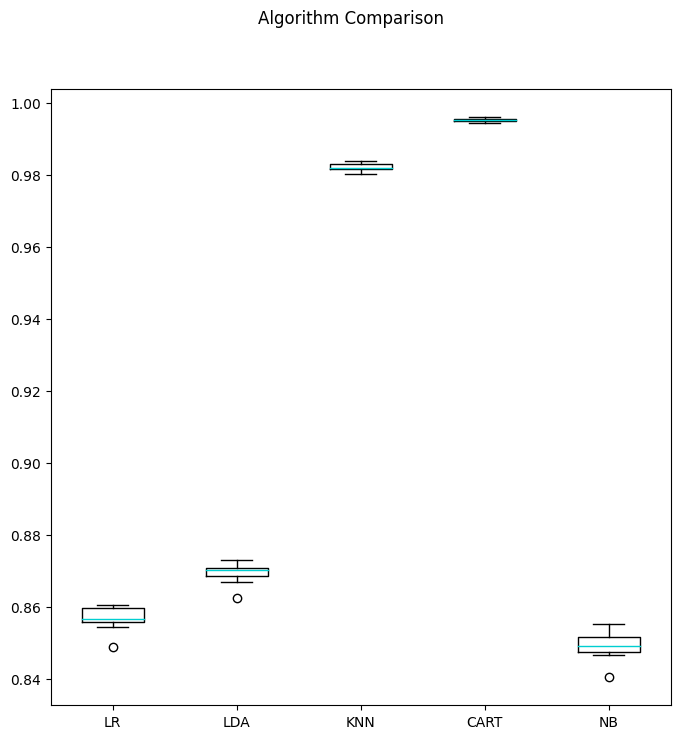

In [ ]:
fig = plt.figure(figsize=(8, 8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
# SCALED MODELS PIPELINE

pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LogisticRegression())])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))
# pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC())])))
results = []
names = []
for name, model in pipelines:
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, X_train_resampled, y_train_resampled, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

ScaledLR: 0.870219 (0.002999)
ScaledLDA: 0.869420 (0.002846)
ScaledKNN: 0.997623 (0.000418)
ScaledCART: 0.995155 (0.000417)
ScaledNB: 0.849012 (0.003810)


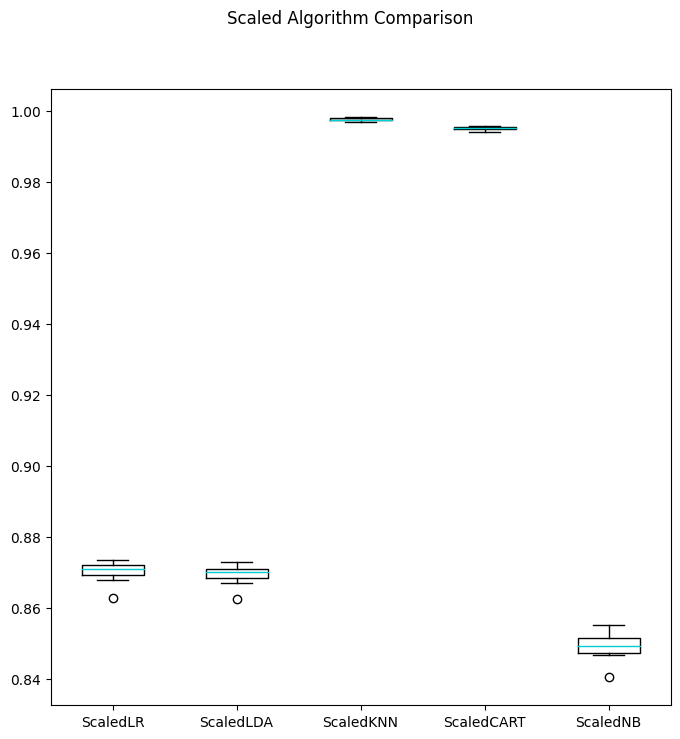

In [ ]:
# Compare Algorithms
fig = plt.figure(figsize=(8, 8))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
results = []
names = []
for name, model in ensembles:
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, X_train_resampled, y_train_resampled, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

AB: 0.999278 (0.000197)
GBM: 0.999491 (0.000154)
RF: 0.999539 (0.000210)
ET: 0.999974 (0.000028)


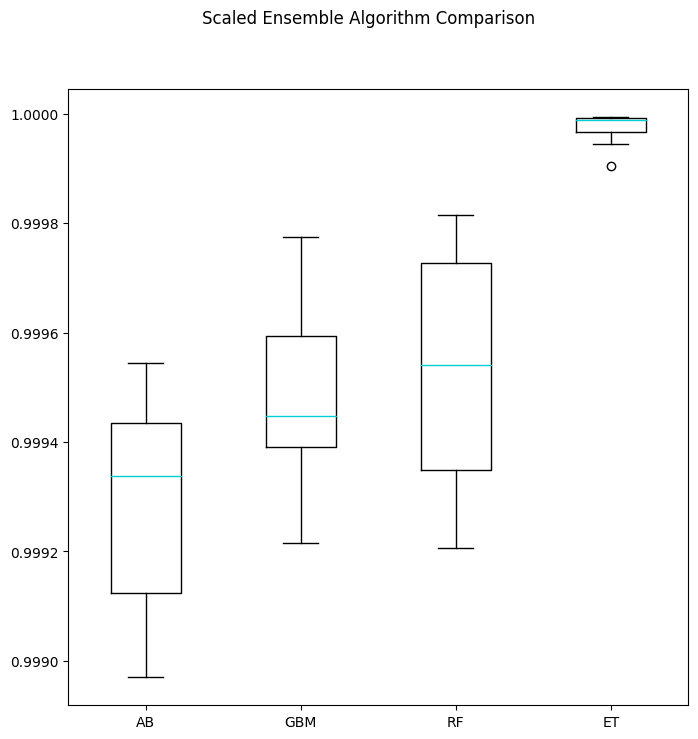

In [ ]:
# Compare Algorithms
fig = plt.figure(figsize=(8, 8))
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Finding: The ET model has the highest performance in ROC AUC score compared with other models

In [ ]:
# Train and save the ExtraTreesClassifier model
rf_model = ExtraTreesClassifier(n_estimators=550)
rf_model.fit(X_train_resampled, y_train_resampled)

# Save the model to a file
model_filename = 'et.pkl'
joblib.dump(rf_model, model_filename)

# Load the saved model
loaded_rf_model = joblib.load(model_filename)

# Make probability predictions on the validation data
probabilities = loaded_rf_model.predict_proba(X_test_prep)
predicted_labels = loaded_rf_model.predict(X_test_prep)

# Calculate AUC score
auc_score = roc_auc_score(y_test, probabilities[:, 1])

# Calculate evaluation metrics
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)
classification_rep = classification_report(y_test, predicted_labels)
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Print the evaluation metrics
print(f"AUC Score: {auc_score:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print("Classification Report:")
print(classification_rep)
print("Confusion Matrix:")
print(conf_matrix)

AUC Score: 0.76
Precision: 0.00
Recall: 0.00
F1-score: 0.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38259
           1       0.00      0.00      0.00       146

    accuracy                           1.00     38405
   macro avg       0.50      0.50      0.50     38405
weighted avg       0.99      1.00      0.99     38405

Confusion Matrix:
[[38250     9]
 [  146     0]]


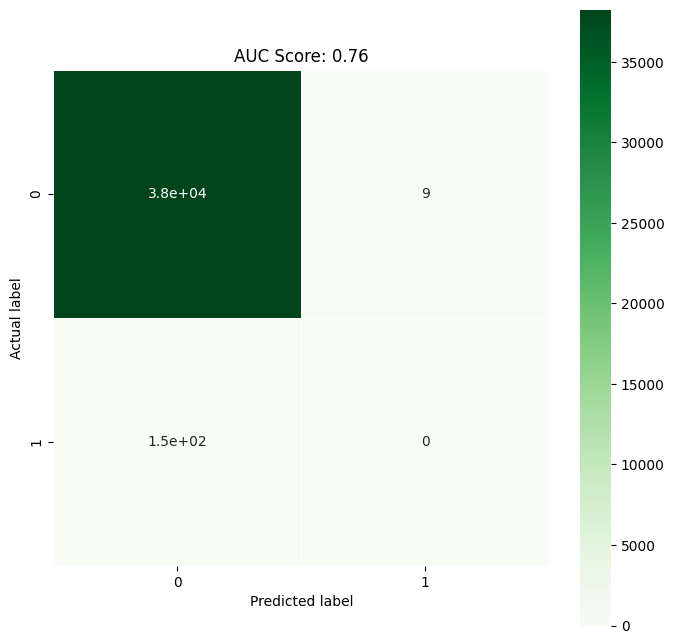

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

# Calculate recall score
recall = recall_score(y_test, predicted_labels)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=.5, square=True, cmap='Greens')

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f'AUC Score: {auc_score:.2f}'
plt.title(all_sample_title, size=12)
plt.show()

In [ ]:
# the end